In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import xarray as xr

### Scientific Question: What is the total magnitude of OCS uptake in East Trout Lake, Canada?

Using data from  NOAA ESRL Global Monitoring Division at the  tower locations of Barrow, Alaska, Alert, Canada, and one flight study in East Trout Lake, Canada. 

Data is customized and found on the NOAA ESRL Global Monitoring Division website: https://www.esrl.noaa.gov/gmd/dv/data/

### Location of the sites:
- ALT: Latitude: 82.4508° North
          Longitude: 62.5072° West
- BRW: Latitude: 71.3230° North
           Longitude: 156.6114° West
- ELT: Latitude: 54.3501° North
         Longitude: 104.9834° West

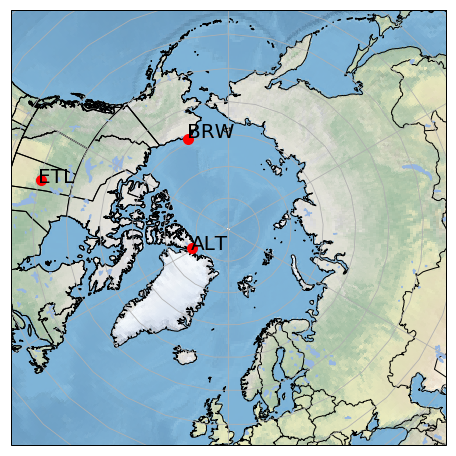

In [3]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 90, 50], ccrs.PlateCarree()) # This was found in the cartopy gallery.

ax.coastlines(resolution='50m')
ax.gridlines()
ax.stock_img()
ax.add_feature(cfeature.STATES.with_scale('50m'))
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.add_feature(cfeature.LAKES.with_scale('50m'))

ax.plot(-62.5072, 82.4508, 'o', color='red', markersize=10, transform=ccrs.Geodetic())
ax.text(-62, 82, 'ALT', fontsize=20, transform=ccrs.Geodetic())

ax.plot(-156.6114, 71.3230, 'o', color='red', markersize=10, transform=ccrs.Geodetic())
ax.text(-156, 71, 'BRW', fontsize=20, transform=ccrs.Geodetic())

ax.plot(-104.9834, 54.3501, 'o', color='red', markersize=10, transform=ccrs.Geodetic())
ax.text(-104, 54, 'ETL', fontsize=20, transform=ccrs.Geodetic());

# Reading Tower Data

In [44]:
df = pd.read_csv('OCS__GCMS_flask.txt', delim_whitespace=True, header=1, parse_dates=['yyyymmdd'], na_values=[-99, 'nd']) # opening the file

df = df.rename(index=str, columns={'yyyymmdd':'date', 'OCS_':'OCS', 'OCS__sd':'OCS_sd'}) # changing the names to make them easier to type

df['year'], df['month'] = df['date'].dt.year, df['date'].dt.month # adding a year and month column to the end, this is important later

df = df.set_index('date') # setting index to date

df.head()

,site,dec_date,hhmmss,wind_dir,wind_spd,OCS,OCS_sd,year,month
date,,,,,,,,,
2000-05-18,alt,2000.37883,1536,235.000,2.254,504.3,1.7,2000,5
2000-06-08,alt,2000.43620,1536,268.100,1.708,498.2,0.5,2000,6
2000-08-11,alt,2000.61099,1457,60.611,3.626,444.4,3.9,2000,8
2000-09-02,alt,2000.67145,1800,123.110,2.940,398.4,0.4,2000,9
2000-11-10,alt,2000.85963,1502,206.190,4.410,422.6,1.7,2000,11


Now, while the OCS data read as a float64, the wind_dir data read as an object, so I had to manually change it to a float64 so I could use it. It was very annoying.

In [10]:
df.wind_dir.head()
df["wind_dir"] = pd.to_numeric(df["wind_dir"])
df.wind_dir.head()

date
2000-05-18    235.000
2000-06-08    268.100
2000-08-11     60.611
2000-09-02    123.110
2000-11-10    206.190
Name: wind_dir, dtype: float64

Now, I'm  going to group into ALT and BRW and call them their own dataframes for analysis.

### ALT Data - Tower

In [56]:
df_alt = df[df.site == 'alt'] 

The wind direction is important for knowing where the plume of air is coming from. There is a small town right next to the monitoring site, so we want to make sure we aren't getting any pollution from them. The clean air comes from the 0 - 45 degree direction, and the land air comes from the 135 - 202 degree direction from the monitoring site.

In [13]:
df_alt_clean = df_alt[(df_alt.wind_dir > 0) & (df_alt.wind_dir < 45)]
df_alt_land = df_alt[(df_alt.wind_dir > 135) & (df_alt.wind_dir < 202)]

Now, plot the two datasets against each other to see if there is a discernable difference between the two sets of data. 

Text(0,0.5,'OCS (ppt)')

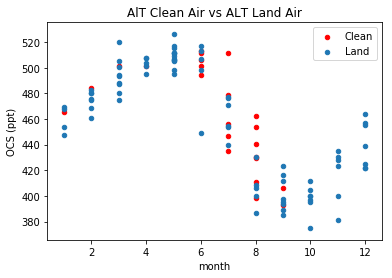

In [59]:
fig, ax = plt.subplots()

df_alt_clean.plot(x='month', y='OCS', kind='scatter', ax=ax, color='red')
df_alt_land.plot(x='month', y='OCS', kind='scatter', ax=ax)

ax.legend(['Clean', 'Land'])
ax.set_title('AlT Clean Air vs ALT Land Air')
ax.set_ylabel('OCS (ppt)')

As we can see, the air is pretty well mixed and there is a seasonality to the data, but both are pretty uniform. There is probably no statistical difference between the different wind directions (not doing a t-test for this assignment).

### BRW Data - Tower

In [57]:
df_brw = df[(df.site == 'brw')]

Similar to ALT, the wind direction matters, so I am grouping into 0 - 45 degree and 135 - 202 degree directions.

In [50]:
df_brw_clean = df_brw[(df_brw.wind_dir > 0) & (df_brw.wind_dir < 45)]
df_brw_land = df_brw[(df_brw.wind_dir > 135) & (df_brw.wind_dir < 202)]

Text(0,0.5,'OCS (ppt)')

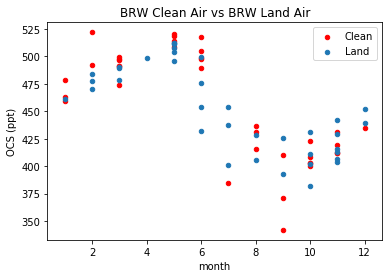

In [58]:
fig, ax = plt.subplots()

df_brw_clean.plot(x='month', y='OCS', kind='scatter', ax=ax, color='red')
df_brw_land.plot(x='month', y='OCS', kind='scatter', ax=ax)

ax.legend(['Clean', 'Land'])
ax.set_title('BRW Clean Air vs BRW Land Air')
ax.set_ylabel('OCS (ppt)')

Again, it is pretty well mixed, so I will use all the data.

## Reading Aircraft Data

The aircraft data is from a different group so I'm going to have to work with it to make it look right and to use with the tower data.

### ETL Data - Aircraft

In [60]:
df_etl = pd.read_csv('merge_etl_aircraft-pfp_1_multi_event_edit.txt', delim_whitespace=True, header=75, 
                     parse_dates=[['sample_year', 'sample_month', 'sample_day']],
                     na_values=[-999.990],
                     ) # reading the data

df_etl = df_etl.rename(index=str, columns={'sample_year_sample_month_sample_day':'date', 'analysis_value.3':'OCS', 'analysis_flag.3':'flag'})
    # making the columns usable names

df_etl['year'], df_etl['month'] = df_etl['date'].dt.year, df_etl['date'].dt.month # adding a year and month column    

df_etl = df_etl.set_index('date') # indexing by date

df_etl = df_etl[(df_etl.OCS != 0) & (df_etl.OCS > 300) & (df_etl.flag == '...')] # getting rid of funky or unusable data (from the read.me file)

df_etl.head()

,sample_site_code,sample_hour,sample_minute,sample_seconds,sample_id,sample_method,sample_latitude,sample_longitude,sample_altitude,sample_elevation,...,parameter_formula.2,analysis_group_abbr.2,analysis_value.2,analysis_flag.2,parameter_formula.3,analysis_group_abbr.3,OCS,flag,year,month
date,,,,,,,,,,,,,,,,,,,,,
2005-10-15,ETL,20,30,48,3071-01,A,54.34,-104.99,7094.70,512.0,...,co2,CCGG,376.70,..P,OCS,HATS,490.985,...,2005,10
2005-10-15,ETL,20,43,1,3071-02,A,54.34,-104.99,5850.07,512.0,...,co2,CCGG,376.91,..P,OCS,HATS,499.241,...,2005,10
2005-10-15,ETL,20,51,35,3071-03,A,54.34,-104.99,4926.58,512.0,...,co2,CCGG,377.27,..P,OCS,HATS,501.304,...,2005,10
2005-10-15,ETL,20,59,48,3071-04,A,54.34,-104.99,3995.55,512.0,...,co2,CCGG,377.76,..P,OCS,HATS,520.697,...,2005,10
2005-10-15,ETL,21,9,33,3071-07,A,54.34,-104.99,2906.96,512.0,...,co2,CCGG,377.72,..P,OCS,HATS,489.282,...,2005,10


According to the read.me file on this data, for OCS a '...' ' flag means good data. I am only looking at OCS for this project. There is also some funny numbers that are clearly wrong, so I have to get rid of those too.

### Filtering the two tower datasets by date to match the limited data in the ETL aircraft dataset.

In [35]:
df_alt_filt = df_alt.loc['2005-10-01':'2016-12-31']
df_brw_filt = df_brw.loc['2005-10-01':'2016-12-31']
# ETl data was from 2005-10-01 to 2016-12-31

Text(0.5,1,'Monthly Mean of ALT, BRW, ETL')

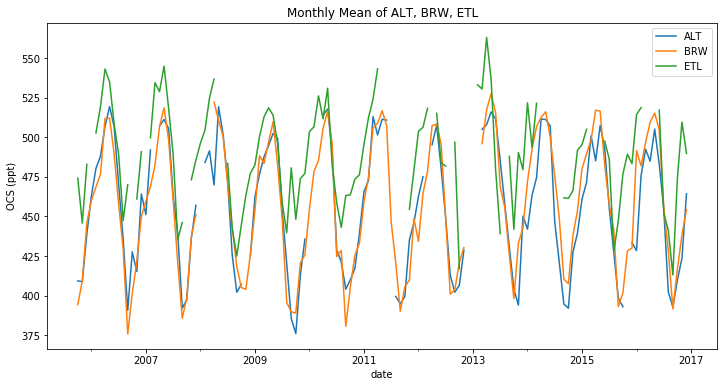

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))

df_alt_filt.resample('M').aggregate({"OCS":np.mean}).plot(ax=ax)
df_brw_filt.resample('M').aggregate({"OCS":np.mean}).plot(ax=ax)
df_etl.resample('M').aggregate({"OCS":np.mean}).plot(ax=ax)

ax.legend(['ALT', 'BRW', 'ETL'])
ax.set_ylabel('OCS (ppt)')
ax.set_title('Monthly Mean of ALT, BRW, ETL')

This is just a plot of the monthly mean at all three sites. The flight data needs to be split by altitude in order to see the real atmospheric OCS background. 

Now looking at values below 2 km and above 4 km (free tropospheric background, well mixed) and above 4 km more similar to BRW and ALT than below 2 km.

In [62]:
df_etl_2 = df_etl[(df_etl.sample_altitude < 2000)] 
df_etl_4 = df_etl[(df_etl.sample_altitude > 4000)] # Tropospheric background, well mixed

Now I want to take the monthly mean for each dataset to compare them to each other:

In [64]:
e4 = df_etl_4.resample('M').aggregate({"OCS":np.mean})
e2 = df_etl_2.resample('M').aggregate({"OCS":np.mean})

a = df_alt_filt.resample('M').aggregate({"OCS":np.mean})
b = df_brw_filt.resample('M').aggregate({"OCS":np.mean})

Plotting each monthly mean:

Text(0.5,1,'High and Low Altitude Monthly Mean of ALT, BRW, ETL')

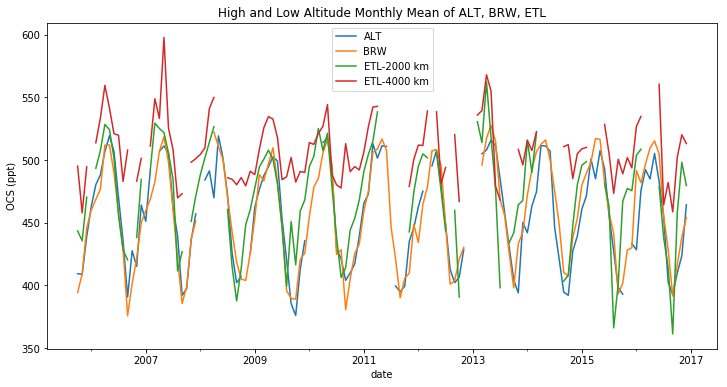

In [65]:
fig, ax = plt.subplots()

a.plot(ax=ax, figsize=(12,6))
b.plot(ax=ax, figsize=(12,6))
e2.plot(ax=ax, figsize=(12,6))
e4.plot(ax=ax, figsize=(12,6))

ax.legend(['ALT', 'BRW', 'ETL-2000 km', 'ETL-4000 km'])
ax.set_ylabel('OCS (ppt)')
ax.set_title('High and Low Altitude Monthly Mean of ALT, BRW, ETL')

Now I need to do a monthly average of the background (ETL-4000 km), then subtract the others from it to get the OCS uptake in the column.

In [66]:
# calculations to subtract the background
t = a - e4
u = b - e4
v = a - e2
w = b - e2

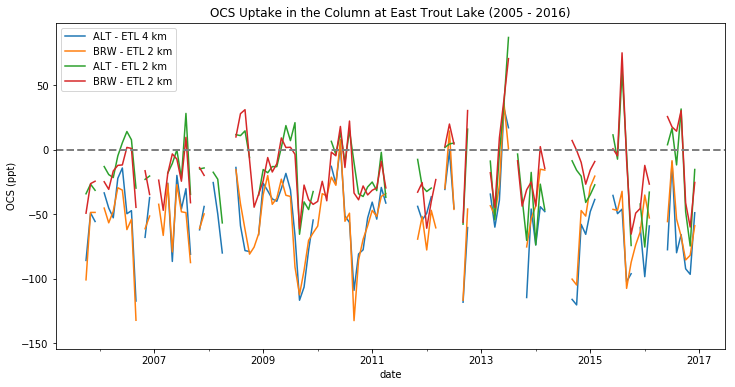

In [78]:
# plot all background differences together:
fig, ax = plt.subplots(figsize=(12, 6))

t.plot(ax=ax)
u.plot(ax=ax)
v.plot(ax=ax)
w.plot(ax=ax)

ax.legend(['ALT - ETL 4 km', 'BRW - ETL 2 km', 'ALT - ETL 2 km', 'BRW - ETL 2 km'])
ax.set_ylabel('OCS (ppt)')
ax.set_title('OCS Uptake in the Column at East Trout Lake (2005 - 2016)')
# add 0 line
ax.axhline(y=0, linestyle='--', lw=2, color='grey')

With this plot you can see the seasonality of the OCS uptake in the column around East Lake Trout, Canada. Negative numbers indicade a negative flux of OCS into the biosphere, and positive numbers indicate a positive flux of OCS into the atmosphere. The background OCS values are ~500 ppt, so losing 100 ppt of OCS in the summer is a significant change in the OCS budget.

Also plot the monthly because there is a seasonality.draw 0 line. indicate surface enhancement and surface depletion. 